In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        continue
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Data Preparation

In [2]:
path = "/kaggle/input/mammals-image-classification-dataset-45-animals/mammals"
dir_path = os.listdir("/kaggle/input/mammals-image-classification-dataset-45-animals/mammals")
paths = []

# Finding paths for all the images
for i in dir_path:
    for j in os.walk(os.path.join(path, i)):
        for k in j[2]:
            paths.append(os.path.join(path, i, k))

In [3]:
# Finding out all the class names
classes = []
for i in paths:
    classes.append(i.split('/')[-2])
classes = np.array(classes)

In [4]:
# Splitting the paths into training and validation paths
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(paths, classes,
                                                    test_size=0.2,
                                                    stratify=classes,
                                                    random_state=42)

len(X_train), len(X_test)

(11000, 2751)

In [17]:
import torch
import cv2
from torch.utils.data import Dataset, DataLoader

class Dataset(Dataset):
    def __init__(self, paths, classes, transforms=None):
        super().__init__()
        self.paths = paths
        self.classes = classes
        self.transforms = transforms
        self.unique_cls = np.array(list(set(classes)))
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        # Loading the image
        image = cv2.resize(cv2.imread(self.paths[idx])/255., (256, 256))
        image = torch.from_numpy(image)
        image = image.to(dtype=torch.float32)
        image = image.permute(2,0,1)
        # Loading the label
        label = self.paths[idx].split('/')[-2]
        label_idx = np.where(self.unique_cls==label)[0][0]
        label = torch.zeros(45, dtype=torch.float32)
        label[label_idx] = 1.0
        return image, label

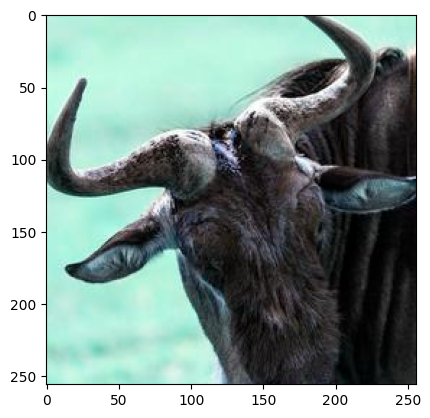

In [6]:
import matplotlib.pyplot as plt

obj = Dataset(paths, classes)
plt.imshow(obj.__getitem__(42)[0].permute(1,2,0))

### Building the model

In [7]:
from tqdm.auto import tqdm
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self, in_features):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding="same")
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding="same")
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding="same")

        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten(start_dim=1)

        self.dense1 = nn.LazyLinear(512)
        self.dense2 = nn.Linear(512, 512)

        self.silu = nn.SiLU()
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(512, 45)

        # Batch normalization layers after convolutions
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

    def forward(self, input_t):
        x = self.silu(self.bn1(self.pool(self.conv1(input_t))))
        x = self.silu(self.bn2(self.pool(self.conv2(x))))
        x = self.silu(self.bn3(self.pool(self.conv3(x))))
        x = self.silu(self.bn4(self.pool(self.conv4(x))))
        x = self.flatten(x)
        x = self.silu(self.dense1(x))
        x = self.dropout(x)
        x = self.silu(self.dense2(x))
        x = self.dropout(x)
        x = self.softmax(self.classifier(x))
        return x
    
# Creating the model
model = CustomCNN(3)

# Running a dummy forward pass
dummy_input = torch.randn(1, 3, 256, 256)
model(dummy_input)

model = nn.DataParallel(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initializing the optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

# Creating datasets
train_data = Dataset(X_train, y_train)
test_data = Dataset(X_test, y_test)

# Creating data loaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True, pin_memory=True)

# Creating a learning rate scheduler
total_batches = len(train_loader)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=0.01, 
    total_steps=total_batches * 20, 
    final_div_factor=10.0
)

# Keeping track of the loss
loss_l = []

# Training loop
for epoch in range(20):
    pbar = tqdm(train_loader, total=len(train_loader))
    for image, label in pbar:
        # Moving the data to GPU
        image = image.to(device)
        label = label.to(device)
        
        # Forward pass
        outputs = model(image)
        loss = criterion(outputs, label)
        loss_l.append(loss.detach().to("cpu"))
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Learning rate scheduler
        lr_scheduler.step()
        
        del image
        del label
        
        pbar.set_description(f"Epoch: {epoch+1}, Loss: {loss.item()}")

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

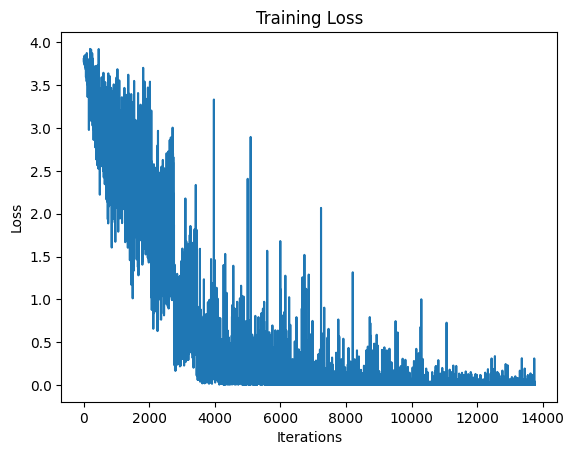

In [8]:
# Plotting the loss
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(loss_l)
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

### Writing the Evaluation Loop

In [9]:
from sklearn.metrics import classification_report

# Model evaluation
def evaluate(model, test_dataloader, criterion):
    # Keeping track of model performance on the test set
    y_true, y_pred = [], []
    # Putting the model in evaluation mode
    model.eval()
    with torch.no_grad():
        pbar = tqdm(test_dataloader, total=len(test_dataloader), desc="Evaluating")
        for text, labels in pbar:
            text = text.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(text)
            # Obtaining the most likely predicted class
            y_pred.extend(torch.argmax(outputs, dim=1).to("cpu"))
            y_true.extend(torch.argmax(labels, dim=1).to("cpu"))
    # Calculating metrics
    print(classification_report(y_true, y_pred))
    
evaluate(model, test_loader, criterion)

Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.24      0.18      0.21        66
           1       0.48      0.49      0.49        61
           2       0.24      0.17      0.20        65
           3       0.27      0.19      0.22        52
           4       0.46      0.56      0.50        61
           5       0.34      0.37      0.35        60
           6       0.50      0.46      0.48        69
           7       0.22      0.19      0.20        63
           8       0.59      0.73      0.65        48
           9       0.53      0.73      0.62        66
          10       0.00      0.00      0.00        62
          11       0.01      0.02      0.02        61
          12       0.03      0.03      0.03        62
          13       0.00      0.00      0.00        63
          14       0.27      0.29      0.28        51
          15       0.30      0.19      0.23        43
          16       0.36      0.32      0.34        56
          17       0.00    

### Data Augmentation

In [30]:
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class AugmentedDataset(Dataset):
    def __init__(self, paths, classes, mode="train"):
        super().__init__()
        self.paths = paths
        self.classes = classes
        self.transforms = transforms
        self.unique_cls = np.array(list(set(classes)))
        self.mode = mode
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        # Loading the image
        image = Image.open(self.paths[idx])
        image = image.resize((256, 256))
        # Data Augmentation
        if self.mode == "train":
            # Data Augmentation
            preprocess = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(256),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            image = preprocess(image)
        else:
            preprocess = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        # Loading the label
        label = self.paths[idx].split('/')[-2]
        label_idx = np.where(self.unique_cls==label)[0][0]
        label = torch.zeros(45, dtype=torch.float32)
        label[label_idx] = 1.0
        return image, label

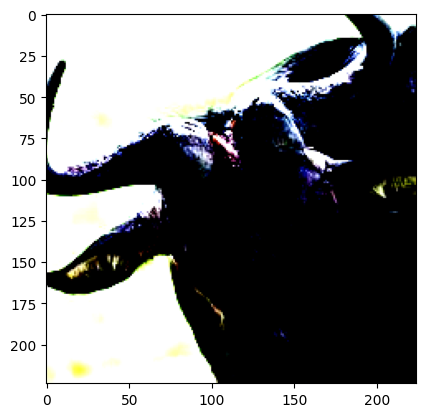

In [19]:
import matplotlib.pyplot as plt

obj = AugmentedDataset(paths, classes)
plt.imshow(obj.__getitem__(42)[0].permute(1,2,0))

In [33]:
import torch
from tqdm.auto import tqdm
from torch import nn
from torchvision import transforms

class CNNWithAugmentation(nn.Module):
    def __init__(self, in_features):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding="same")
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding="same")
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding="same")

        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten(start_dim=1)

        self.dense1 = nn.LazyLinear(512)
        self.dense2 = nn.Linear(512, 512)

        self.silu = nn.SiLU()
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(512, 45)

        # Batch normalization layers after convolutions
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

    def forward(self, input_t):
        x = self.silu(self.bn1(self.pool(self.conv1(input_t))))
        x = self.silu(self.bn2(self.pool(self.conv2(x))))
        x = self.silu(self.bn3(self.pool(self.conv3(x))))
        x = self.silu(self.bn4(self.pool(self.conv4(x))))
        x = self.flatten(x)
        x = self.silu(self.dense1(x))
        x = self.dropout(x)
        x = self.silu(self.dense2(x))
        x = self.dropout(x)
        x = self.softmax(self.classifier(x))
        return x
    
# Creating the model
model = CNNWithAugmentation(3)

# Running a dummy forward pass
dummy_input = torch.randn(1, 3, 256, 256)
model(dummy_input)

model = nn.DataParallel(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initializing the optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

# Creating augmented datasets
train_data = AugmentedDataset(X_train, y_train)
test_data = AugmentedDataset(X_test, y_test)

# Creating data loaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True, pin_memory=True)

# Creating a learning rate scheduler
total_batches = len(train_loader)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=0.01, 
    total_steps=total_batches * 20, 
    final_div_factor=10.0
)

# Keeping track of the loss
loss_l = []

# Training loop
for epoch in range(20):
    pbar = tqdm(train_loader, total=len(train_loader))
    for image, label in pbar:
        # Moving the data to GPU
        image = image.to(device)
        label = label.to(device)
        
        # Forward pass
        outputs = model(image)
        loss = criterion(outputs, label)
        loss_l.append(loss.detach().to("cpu"))
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Learning rate scheduler
        lr_scheduler.step()
        
        del image
        del label
        
        pbar.set_description(f"Epoch: {epoch+1}, Loss: {loss.item()}")

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

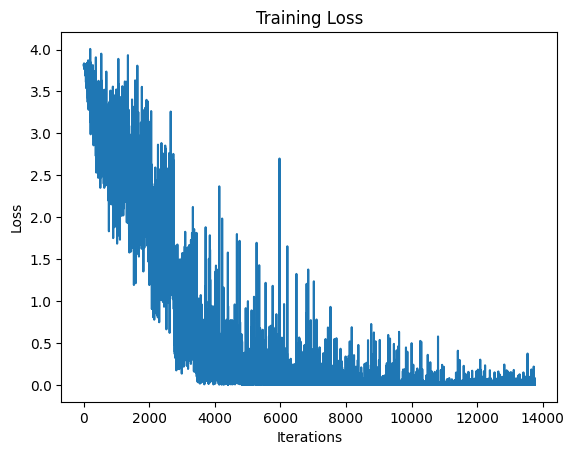

In [34]:
# Plotting the loss
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(loss_l)
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

### Evaluation Loop for Augmented Dataset

In [35]:
from sklearn.metrics import classification_report

# Model evaluation
def evaluate(model, test_dataloader, criterion):
    # Keeping track of model performance on the test set
    y_true, y_pred = [], []
    # Putting the model in evaluation mode
    model.eval()
    with torch.no_grad():
        pbar = tqdm(test_dataloader, total=len(test_dataloader), desc="Evaluating")
        for text, labels in pbar:
            text = text.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(text)
            # Obtaining the most likely predicted class
            y_pred.extend(torch.argmax(outputs, dim=1).to("cpu"))
            y_true.extend(torch.argmax(labels, dim=1).to("cpu"))
    # Calculating metrics
    print(classification_report(y_true, y_pred))
    
evaluate(model, test_loader, criterion)

Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.23      0.24      0.24        66
           1       0.40      0.48      0.44        61
           2       0.24      0.15      0.19        65
           3       0.30      0.29      0.29        52
           4       0.46      0.43      0.44        61
           5       0.36      0.30      0.33        60
           6       0.44      0.52      0.48        69
           7       0.16      0.16      0.16        63
           8       0.48      0.73      0.58        48
           9       0.61      0.61      0.61        66
          10       0.02      0.02      0.02        62
          11       0.02      0.02      0.02        61
          12       0.03      0.03      0.03        62
          13       0.03      0.03      0.03        63
          14       0.20      0.16      0.18        51
          15       0.29      0.21      0.24        43
          16       0.40      0.41      0.41        56
          17       0.00    

# End